%%latex
# Анализ объектов

Возьмите датасет вашего варианта из лабораторной работы № 1. Если вы раньше применяли бинаризацию целевого признака, то сейчас этого делать не нужно.

In [2]:
import pandas as pd

data = pd.read_csv('Automobile.csv')
data = data.drop(columns=['name', 'origin'])
data.dropna(inplace=True)

X = data.drop(columns=['model_year'])
y = data['model_year']
print(X.head())
print(y.head())

    mpg  cylinders  displacement  horsepower  weight  acceleration
0  18.0          8         307.0       130.0    3504          12.0
1  15.0          8         350.0       165.0    3693          11.5
2  18.0          8         318.0       150.0    3436          11.0
3  16.0          8         304.0       150.0    3433          12.0
4  17.0          8         302.0       140.0    3449          10.5
0    70
1    70
2    70
3    70
4    70
Name: model_year, dtype: int64


## Выступ (отступ)

Выступ - это такая функция M(x), что для объектов, лежащих глубоко внутри своего класса, т.е. для эталонов она принимает большие положительные значения. Для периферийных объектов, лежащих на границе классов, M(x)≈0. Для объектов одного класса, расположенных среди объектов другого класса, выступ M(x) должен принимать отрицательные значения. Так как границы классов зачастую нельзя четко определить, то объекты последнего типа с M(x)<0 делят на две подгруппы: ошибочные, для которых алгоритм не может четко определить границу между классами и ошибается (их может быть много, они граничат с периферийными) и случайные выбросы (outliers) - редкие непонятные объекты с M(x)<<0.

Для задачи классификации и некоторого алгоритма, возвращающего вероятности p(y|x) можно определить M для объекта x с правильным ответом y следующим образом: 

$$M(x) = p(y|x) - \max\limits_{s\neq y} p(s|x)$$

Для задачи регрессии можно в качестве выступа брать минус ошибку предсказания.

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_predict

# Инициализируем модели
et_model = ExtraTreesRegressor(random_state=42)
knn_model = KNeighborsRegressor(n_neighbors=5)

# Сбрасываем индексы для X и y, чтобы избежать проблем с несоответствием
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
data = data.reset_index(drop=True)

# Получаем предсказания с помощью кросс-валидации (5 фолдов)
y_pred_et = cross_val_predict(et_model, X, y, cv=5)
y_pred_knn = cross_val_predict(knn_model, X, y, cv=5)

# Вычисляем выступы: M(x) = -|y_true - y_pred|
M_et = -np.abs(y - y_pred_et)
M_knn = -np.abs(y - y_pred_knn)

# Создаём DataFrame с выступами и целевым признаком
results = pd.DataFrame({
    'M_et': M_et,
    'M_knn': M_knn,
    'model_year': y,
    'index': X.index
})

# Сортируем по выступу для ExtraTrees и KNN
outliers_et = results.sort_values(by='M_et').head(10)
outliers_knn = results.sort_values(by='M_knn').head(10)

Возмите два алгоритма древовидный (ExtraTreesClassifier/Regressor или GradientBoostingClassifier/Regressor) и ближайших соседей (KNeighborsClassifier/Regressor). 

С помощью cross_val_predict вычислите предсказания (для задачи склассификации - вероятности) и найдите выступы всех объектов. 

Постройте на одном графике две кривые (для деревьев и KNN): зависимость выступа от номера объекта в отсортированном по выступам ряду объектов. 

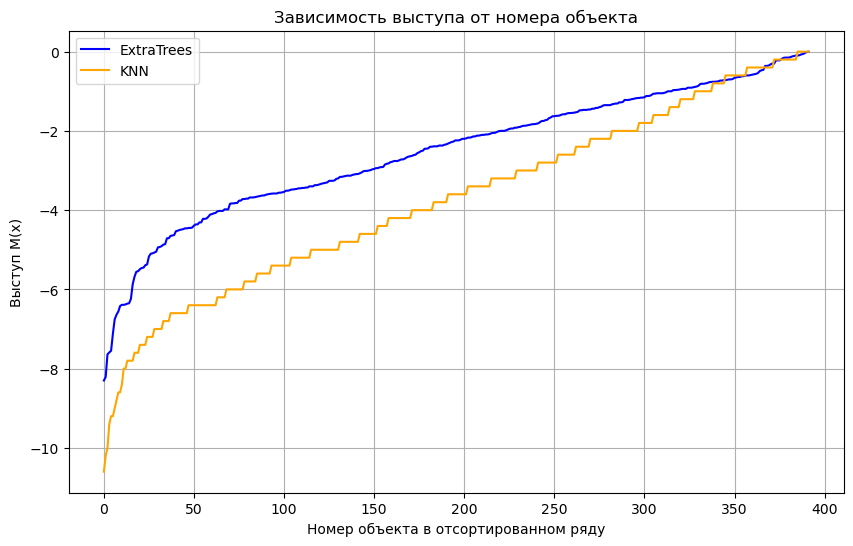

In [8]:
import matplotlib.pyplot as plt

# Сортируем объекты по значению выступа
sorted_et = results.sort_values(by='M_et')
sorted_knn = results.sort_values(by='M_knn')

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(range(len(sorted_et)), sorted_et['M_et'], label='ExtraTrees', color='blue')
plt.plot(range(len(sorted_knn)), sorted_knn['M_knn'], label='KNN', color='orange')
plt.xlabel('Номер объекта в отсортированном ряду')
plt.ylabel('Выступ M(x)')
plt.title('Зависимость выступа от номера объекта')
plt.legend()
plt.grid(True)
plt.show()

Выведите на экран 4 случайных выброса с разными значениями целевого признака и объясните эти аномалии в данных (20% баллов - за правильное объяснение). Вам помогут: важные признаки, найденные в предыдущей лаб. работе, и коэффициенты корреляции. ВАЖНО: выступ характеризует не "абстрактную" типичность объекта, а качество предсказания целевого признака!

In [10]:
# Выбираем 4 объекта с разными значениями model_year для каждой модели
outliers_et = outliers_et.groupby('model_year').first().reset_index()
outliers_knn = outliers_knn.groupby('model_year').first().reset_index()

if len(outliers_et) > 4:
    outliers_et = outliers_et.sample(4, random_state=42)
if len(outliers_knn) > 4:
    outliers_knn = outliers_knn.sample(4, random_state=42)

# Добавляем исходные признаки для анализа
outliers_data_et = data.loc[outliers_et['index']].copy()
outliers_data_et['M_et'] = outliers_et['M_et'].values
outliers_data_et['predicted_year'] = y_pred_et[outliers_et['index'].values]

outliers_data_knn = data.loc[outliers_knn['index']].copy()
outliers_data_knn['M_knn'] = outliers_knn['M_knn'].values
outliers_data_knn['predicted_year'] = y_pred_knn[outliers_knn['index'].values]

# Проверяем согласованность
outliers_data_et['M_et_check'] = -np.abs(outliers_data_et['model_year'] - outliers_data_et['predicted_year'])
outliers_data_knn['M_knn_check'] = -np.abs(outliers_data_knn['model_year'] - outliers_data_knn['predicted_year'])

# Выводим результаты
print("Итоговые выбросы для ExtraTrees (ошибка M_et, предсказание M_et):")
print(outliers_data_et[['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'M_et', 'predicted_year', 'M_et_check']])

print("\nИтоговые выбросы для KNN (ошибка M_knn, предсказание KNN):")
print(outliers_data_knn[['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'M_knn', 'predicted_year', 'M_knn_check']])

Итоговые выбросы для ExtraTrees (ошибка M_et, предсказание M_et):
      mpg  cylinders  displacement  horsepower  weight  acceleration  \
53   35.0          4          72.0        69.0    1613          18.0   
383  22.0          6         232.0       112.0    2835          14.7   
262  18.1          8         302.0       139.0    3205          11.2   
0    18.0          8         307.0       130.0    3504          12.0   

     model_year  M_et  predicted_year  M_et_check  
53           71 -7.12           78.12       -7.12  
383          82 -8.21           73.79       -8.21  
262          78 -6.56           71.44       -6.56  
0            70 -8.30           78.30       -8.30  

Итоговые выбросы для KNN (ошибка M_knn, предсказание KNN):
      mpg  cylinders  displacement  horsepower  weight  acceleration  \
24   21.0          6         199.0        90.0    2648          15.0   
32   19.0          6         232.0       100.0    2634          13.0   
338  30.0          4         135.0   

## Сгущения данных

Найдите в ваших данных сгущения. 
* Для этого попробуйте сначала посмотреть на график рассеяния на главных компонентах. Двумерный рисунок является проекцией многомерной выборки и не позволяет качественно обнаружить сгущения. Чтобы как-то увидеть кластеры, отобразите цветом плотность точек (вычисленную для исходного многомерного пространства). Максимумы плотности покажут проекции сгущений в ваших данных. 

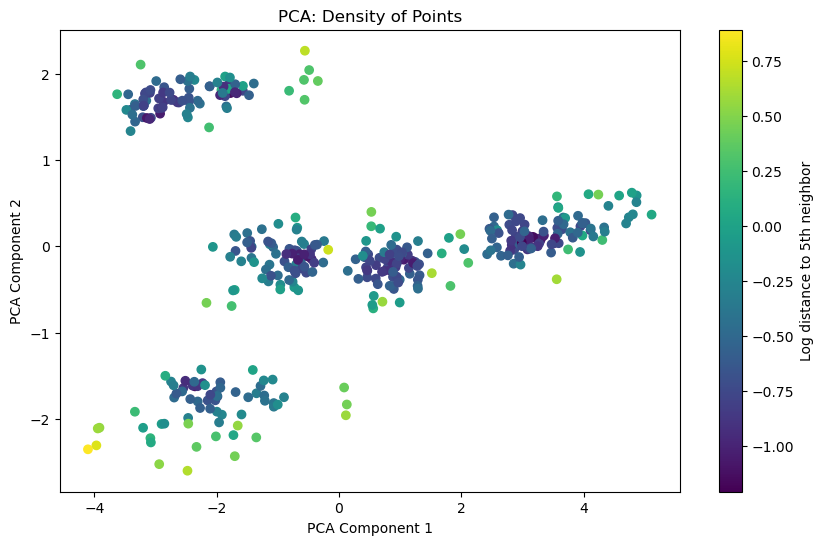

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from scipy.spatial import distance
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
data = pd.read_csv('Automobile.csv')
data.dropna(inplace=True)
label = 'model_year'

# Удаляем столбец name, если он есть
if 'name' in data.columns:
    data = data.drop(columns=['name'])

# One-hot encoding для origin
data = pd.get_dummies(data, columns=['origin'], prefix='origin')

# Разделяем признаки и целевую переменную
X = data.drop(columns=[label])
y = data[label]

# Нормировка признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(X_scaled)

# Вычисляем плотность через расстояние до min_samples-го соседа
min_samples = 5
d = distance.cdist(X_scaled, X_scaled)
r = np.partition(d, min_samples, axis=1)[:, min_samples]

# График PCA с плотностью
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=np.log(r), cmap='viridis')
plt.colorbar(scatter, label='Log distance to 5th neighbor')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA: Density of Points')
plt.show()


* Если вы не увидели сгущения с помощью PCA, примените [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) и нарисуйте аналогичный график рассеяния. Поймите и запишите в ответе физический смысл найденных сгущений данных (20% баллов). Это можно сделать, взяв наугад точки внутри кластеров в embadding (т.е. на графике рассеяния) и применив обратное преобразование. Другой хороший прием: строить графики рассеяния, перебирая в качестве цвета различные признаки. Нам нужны те, для которых сгущения красятся в разный цвет.

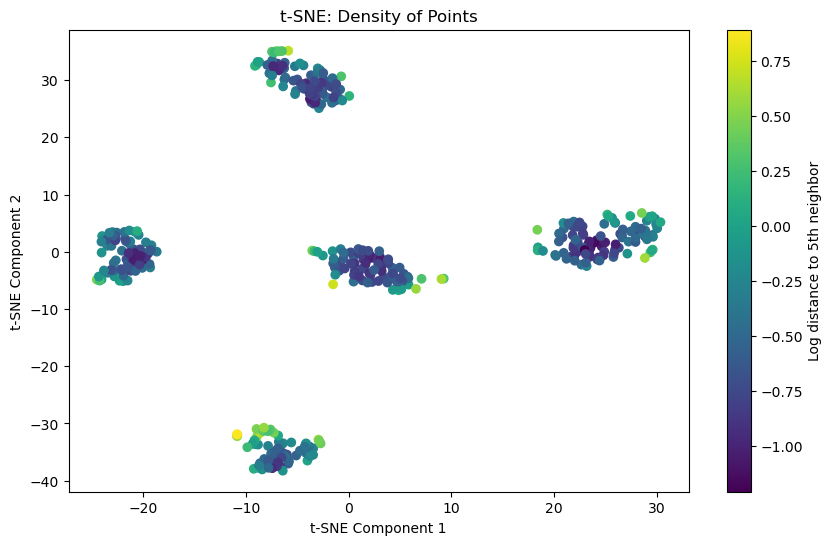

In [22]:
# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(X_scaled)

# График t-SNE с плотностью
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=np.log(r), cmap='viridis')
plt.colorbar(scatter, label='Log distance to 5th neighbor')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE: Density of Points')
plt.show()

* Теперь наши сгущения требуется найти точно. Примените [один из методов кластеризации sklearn](https://scikit-learn.org/stable/modules/clustering.html) к нормализованной выборке со всеми признаками без целевого (или к выборке в embadding пространстве). Отобразите на двумерном графике рассеяния на главных компонентах (или в пространстве t-SNE) разным цветом получившиеся кластеры. Нужно так подобрать параметры алгоритма, чтобы он вернул те же кластеры, которые вы наблюдали в предыдущем пункте. При выборе алгоритма будьте внимательны: многие из них основаны на близости точек, а не на связанности кластеров, поэтому при применении к равномерно распределенной на квадрате выборке возвращают фиктивные кластеры. Я вам советую применять DBSCAN. Чтобы подобрать его параметр eps, для некоторого min_samples, постройте график отсортированных расстояний до ближайшего соседа № min_samples и найдите по нему 90% квантиль

Полезный код: вместо расчета плотности точек можно использовать расстояние до n-того соседа. Чтобы посчитать расстояния за разумное время лучше всего использовать пару функций:
```
d = scipy.spatial.distance.cdist(x, x)  # расчет расстояний от каждой точки выборки x до каждой (одна точка - одна строчка матрицы x)
r = np.partition(d, min_samples, axis=1)[:,min_samples]  # поиск min_samples минимальных элементов
```
Если цвета плотности почти всех точек совпадают, попробуйте логарифмировать r: `hue=np.log(r)`

На графике отсортированных расстояний до ближайшего соседа удобно включать логарифмический масштаб по оси y: `plt.yscale('log')`

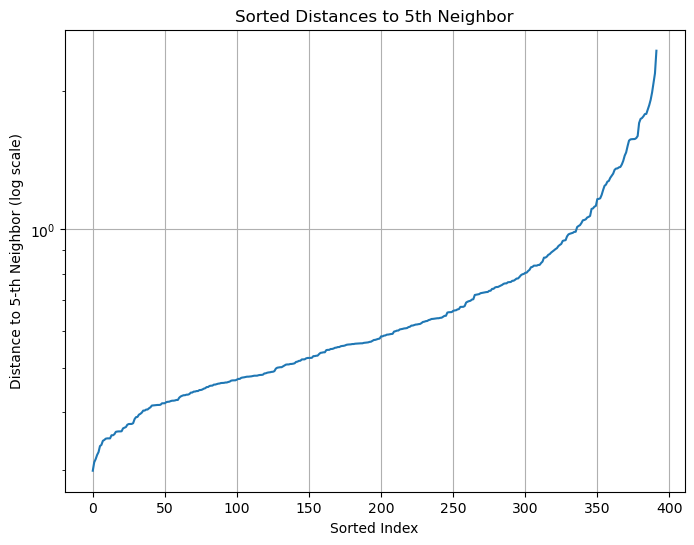

Выбранный eps: 0.9808478747583996


In [25]:
# Подбор eps для DBSCAN
plt.figure(figsize=(8, 6))
plt.plot(np.sort(r))
plt.yscale('log')
plt.xlabel('Sorted Index')
plt.ylabel(f'Distance to {min_samples}-th Neighbor (log scale)')
plt.title('Sorted Distances to 5th Neighbor')
plt.grid(True)
plt.show()

# Настраиваем eps для получения ~5 кластеров
eps = np.percentile(r, 85)  # Уменьшаем до 85% для большего числа кластеров
print(f"Выбранный eps: {eps}")

# DBSCAN на исходных данных
eps = 0.5  # или другое оптимальное значение (нужно определить)
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(X_scaled)

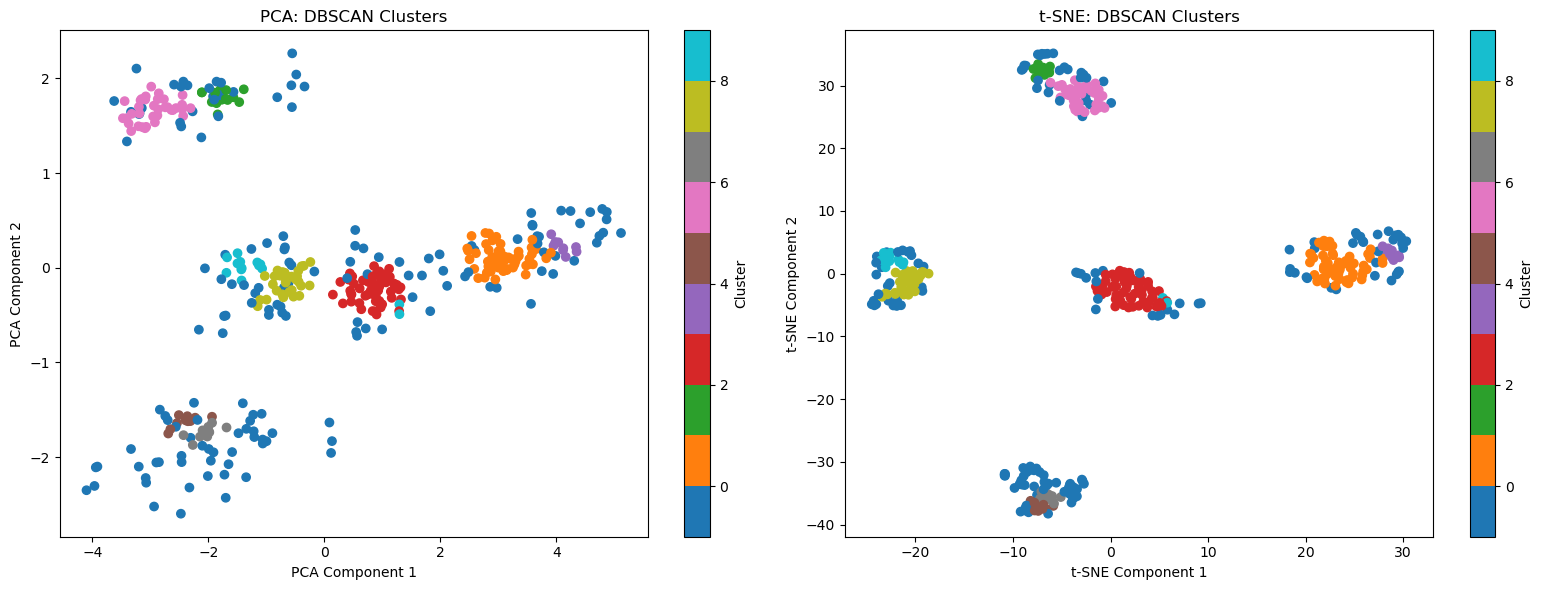

In [29]:
# Создаем фигуру с двумя осями (2 графика слева направо)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Визуализация кластеров на PCA
scatter2 = axes[0].scatter(pca_features[:, 0], pca_features[:, 1], c=clusters, cmap='tab10')
fig.colorbar(scatter2, ax=axes[1], label='Cluster')
axes[0].set_xlabel('PCA Component 1')
axes[0].set_ylabel('PCA Component 2')
axes[0].set_title('PCA: DBSCAN Clusters')

# Визуализация кластеров на t-SNE
scatter1 = axes[1].scatter(tsne_features[:, 0], tsne_features[:, 1], c=clusters, cmap='tab10')
fig.colorbar(scatter1, ax=axes[0], label='Cluster')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
axes[1].set_title('t-SNE: DBSCAN Clusters')


plt.tight_layout()
plt.show()


In [31]:
# Количество точек в каждом кластере
unique, counts = np.unique(clusters, return_counts=True)
print("Кластеры и их размеры:", dict(zip(unique, counts)))

Кластеры и их размеры: {-1: 155, 0: 56, 1: 14, 2: 56, 3: 10, 4: 11, 5: 36, 6: 10, 7: 30, 8: 2, 9: 12}


In [33]:
# Средние признаки по кластерам (включая model_year)
print("\nСредние признаки по кластерам (включая model_year):")
data_with_target = data.copy()  # Включаем model_year
for cluster in np.unique(clusters):
    if cluster != -1:  # Исключаем шум
        print(f"\nКластер {cluster}:")
        print(data_with_target[clusters == cluster].mean())


Средние признаки по кластерам (включая model_year):

Кластер 0:
mpg                15.114286
cylinders           8.000000
displacement      326.964286
horsepower        148.339286
weight           4054.285714
acceleration       13.166071
model_year         74.517857
origin_europe       0.000000
origin_japan        0.000000
origin_usa          1.000000
dtype: float64

Кластер 1:
mpg                24.692857
cylinders           4.000000
displacement      116.357143
horsepower         94.428571
weight           2384.642857
acceleration       14.792857
model_year         73.857143
origin_europe       0.000000
origin_japan        1.000000
origin_usa          0.000000
dtype: float64

Кластер 2:
mpg                19.360714
cylinders           6.000000
displacement      228.232143
horsepower         98.035714
weight           3243.464286
acceleration       16.587500
model_year         75.428571
origin_europe       0.000000
origin_japan        0.000000
origin_usa          1.000000
dtype: floa

In [35]:
# Выбор случайных точек из каждого кластера
np.random.seed(42)
dense_points = []
for cluster in np.unique(clusters):
    if cluster != -1:  # Исключаем шум
        cluster_indices = np.where(clusters == cluster)[0]
        if len(cluster_indices) > 0:
            # Выбираем до 3 случайных точек из кластера
            selected_indices = np.random.choice(cluster_indices, size=min(3, len(cluster_indices)), replace=False)
            dense_points.extend(selected_indices)

# Показываем признаки выбранных точек
print("\nПризнаки точек в сгущениях:")
dense_data = data_with_target.iloc[dense_points]
dense_data['cluster'] = clusters[dense_points]
print(dense_data)


Признаки точек в сгущениях:
      mpg  cylinders  displacement  horsepower  weight  acceleration  \
2    18.0          8         318.0       150.0    3436          11.0   
41   14.0          8         318.0       150.0    4096          13.0   
187  17.5          8         305.0       140.0    4215          13.0   
267  27.5          4         134.0        95.0    2560          14.2   
171  24.0          4         134.0        96.0    2702          13.5   
57   24.0          4         113.0        95.0    2278          15.5   
24   21.0          6         199.0        90.0    2648          15.0   
202  17.5          6         258.0        95.0    3193          17.8   
199  20.0          6         225.0       100.0    3651          17.7   
104  12.0          8         400.0       167.0    4906          12.5   
42   12.0          8         383.0       180.0    4955          11.5   
44   13.0          8         400.0       175.0    5140          12.0   
197  29.0          4          90.0 

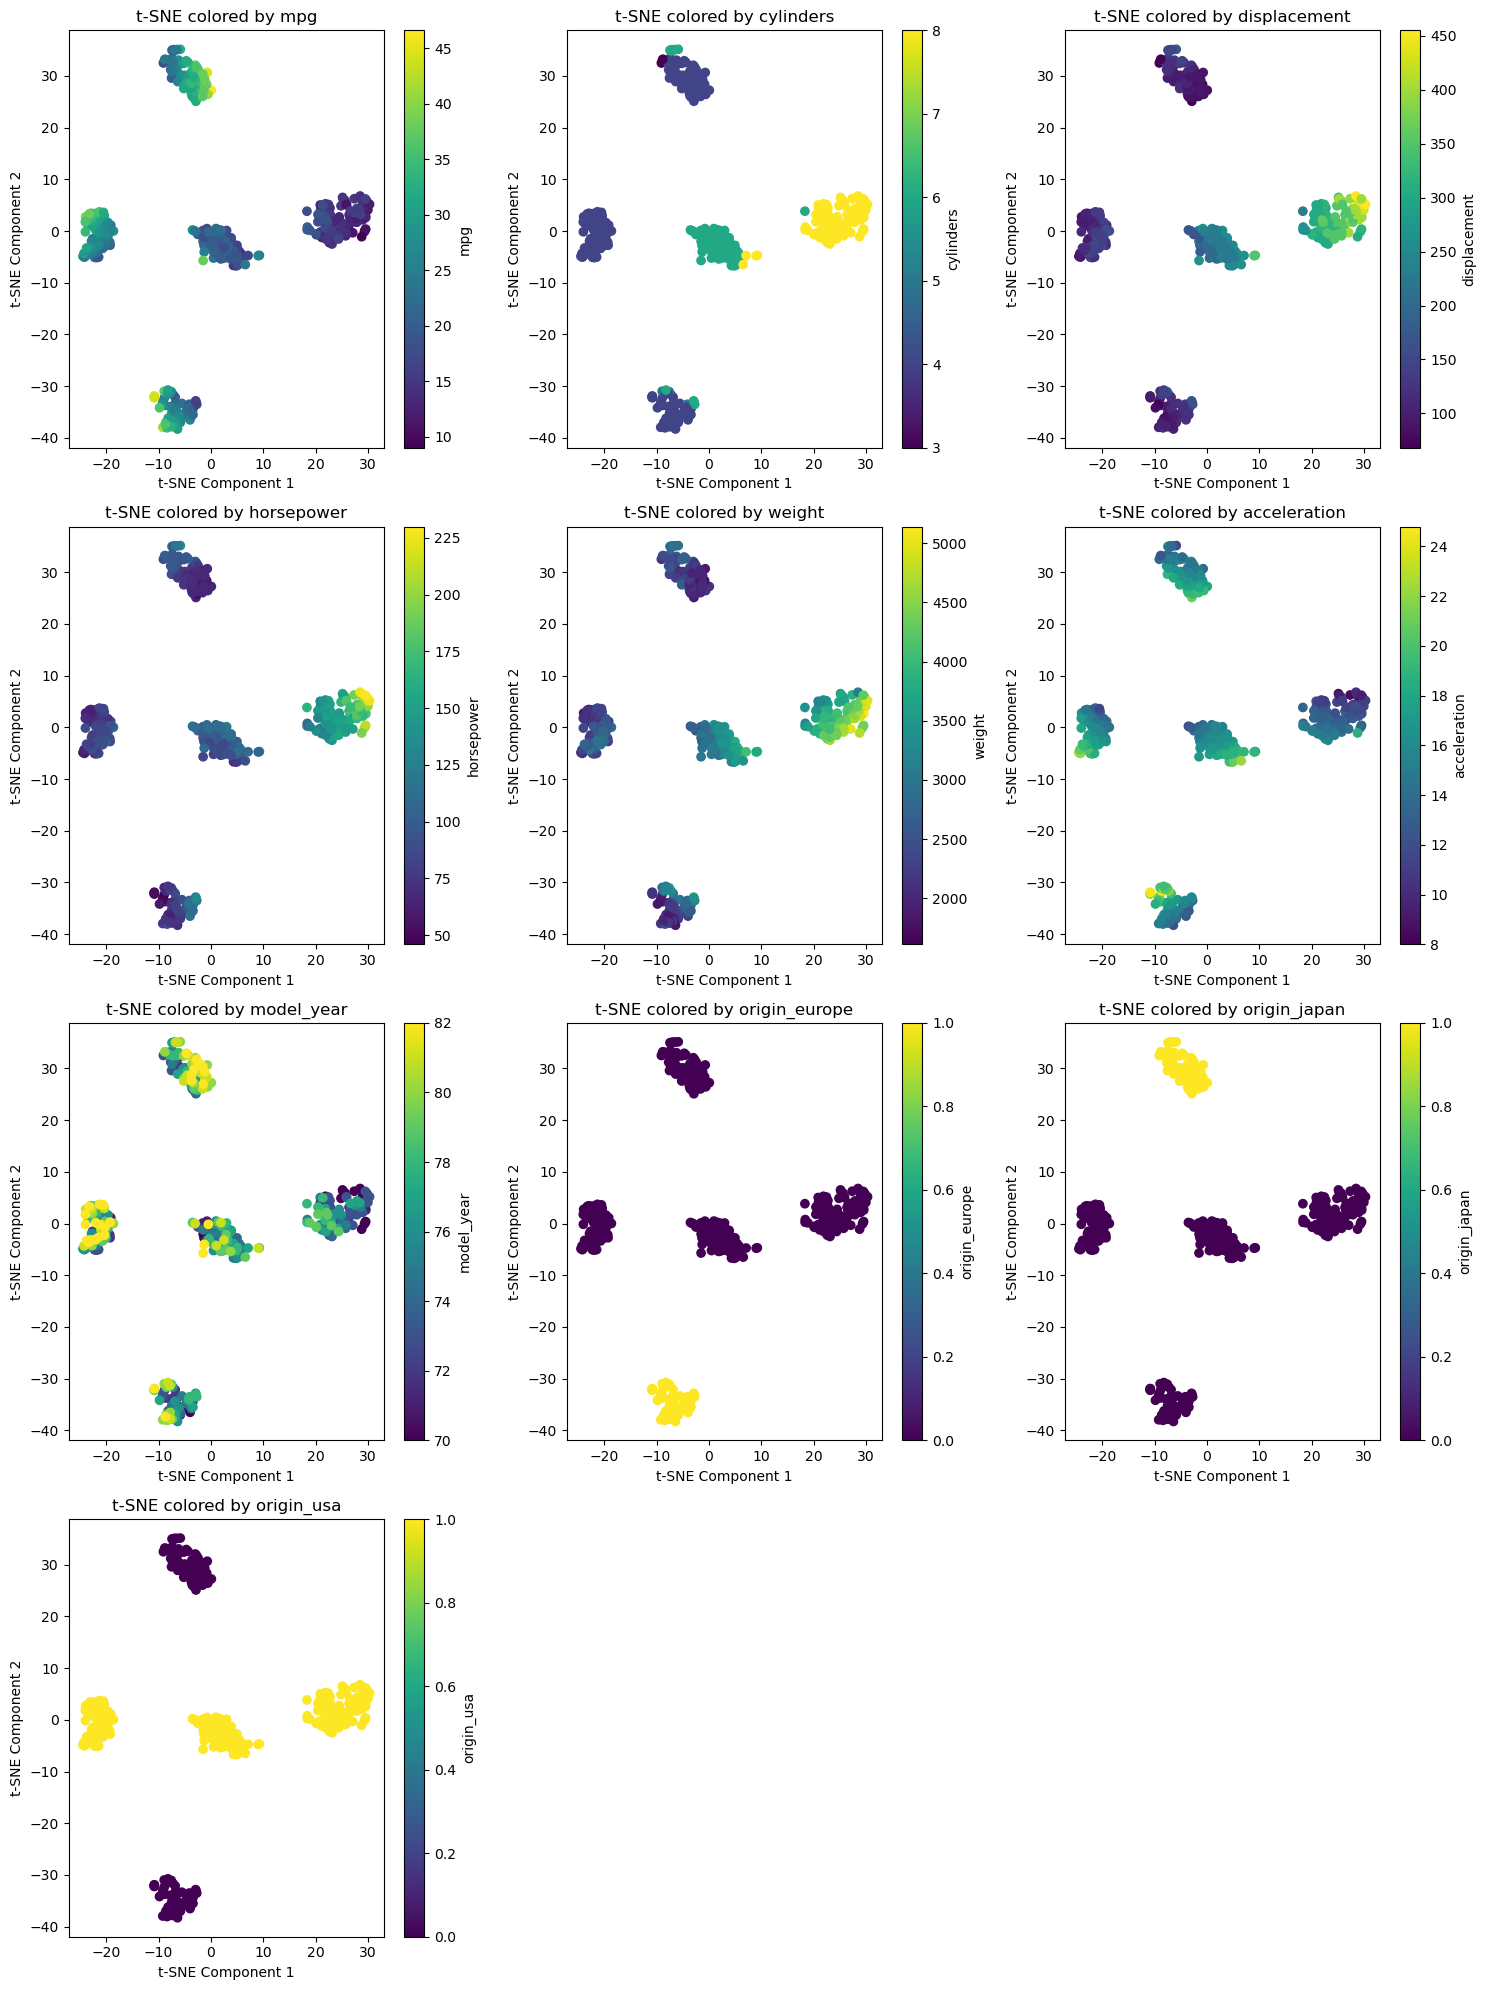

In [37]:
# Графики рассеяния с цветом по всем признакам
features_to_plot = data_with_target.columns  # Все признаки, включая model_year
n_features = len(features_to_plot)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(15, 5 * n_rows))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(n_rows, n_cols, i)
    scatter = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=data_with_target[feature], cmap='viridis')
    plt.colorbar(scatter, label=feature)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title(f't-SNE colored by {feature}')
plt.tight_layout()
plt.show()